1. Скачать видео:
https://www.youtube.com/watch?v=NdSqAAT28v0

In [2]:
import os
!yt-dlp 'https://www.youtube.com/watch?v=NdSqAAT28v0' -o 'video.webm'

[youtube] Extracting URL: https://www.youtube.com/watch?v=NdSqAAT28v0
[youtube] NdSqAAT28v0: Downloading webpage
[youtube] NdSqAAT28v0: Downloading ios player API JSON
[youtube] NdSqAAT28v0: Downloading player 4b63a6a1
[youtube] NdSqAAT28v0: Downloading m3u8 information
[info] NdSqAAT28v0: Downloading 1 format(s): 244+251
[download] Destination: Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].f244.webm
[download] 100% of  275.72MiB in 00:00:34 at 7.90MiB/s0;33m00:000m
[download] Destination: Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].f251.webm
[download] 100% of   74.04MiB in 00:00:07 at 9.59MiB/s0;33m00:000m
[Merger] Merging formats into "Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].webm"
Deleting original file Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].f251.webm (pass -k to keep)
Deleting original file Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [N

2. Средствами библиотек Python извлечь из видео кадры (в оригинале извлекался каждый третий кадр).

In [74]:
import cv2

vidcap = cv2.VideoCapture('video.webm')

In [75]:
import os

os.makedirs('video_frames', exist_ok=True)

frame_margin = 3

success, image = vidcap.read()
count = 1
alt_count = 1
while success:
    if count % frame_margin == 0:
        cv2.imwrite(os.path.join("video_frames", f"image_{alt_count}.png"), image)
        alt_count += 1
    success, image = vidcap.read()
    count += 1


3. Средствами библиотек Python преобразовать разрешение кадров 1920x1080 -> 96x54 (можно другое соотношение).

In [3]:
import cv2, os
import numpy as np

os.makedirs('video_frames_small', exist_ok=True)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
for image_name in os.listdir('video_frames'):
    image = cv2.imread(os.path.join('video_frames', image_name))
    image = cv2.filter2D(image, kernel=kernel, ddepth=-5)
    image = cv2.resize(image, (96, 54))
    cv2.imwrite(os.path.join("video_frames_small", image_name), image)

4. Средствами библиотек Python перевести в черно-белое изображение (белый фон, черная фигура)

In [13]:
import cv2, os
import numpy as np

os.makedirs('video_frames_bw', exist_ok=True)
for image_name in os.listdir('video_frames_small'):
    image = cv2.imread(os.path.join('video_frames_small', image_name), 1)
    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 5, 255, cv2.THRESH_BINARY)
    image[alpha.astype(bool), :] = [255, 255, 255]
    image[np.logical_not(alpha.astype(bool)), :] = [0, 0, 0]

    cv2.imwrite(os.path.join("video_frames_bw", image_name), image)

5. Обучить в Pytorch автоэнкодер (с помощью полносвязных слоев или, как в видео, сверточных) так, чтобы каждое изображение кодировалось вектором длины 128.

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [4]:
images = []
for image_name in os.listdir("video_frames_bw"):
    image_full_path = os.path.join("video_frames_bw", image_name)
    image = cv2.imread(image_full_path)[:, :, 1]
    images.append(image)
images = np.array(images)

In [5]:
from keras import layers
from keras import models

IMAGE_SHAPE = (54, 96)


def build_autoencoder_parts(img_shape, code_size):
    # The encoder
    encoder = models.Sequential()
    encoder.add(layers.InputLayer(img_shape))
    encoder.add(layers.Flatten()),
    encoder.add(layers.Dense(512, activation='relu'))
    encoder.add(layers.Dense(code_size))

    # The decoder
    decoder = models.Sequential()
    decoder.add(layers.InputLayer((code_size,)))
    decoder.add(layers.Dense(512, activation='relu'))
    decoder.add(layers.Dense(np.prod(img_shape)))
    decoder.add(layers.Reshape(img_shape))

    return encoder, decoder


def build_auto_encoder(img_shape, encoder, decoder):
    inp = layers.Input(img_shape)
    code = encoder(inp)
    reconstruction = decoder(code)

    auto_encoder = models.Model(inp, reconstruction)
    auto_encoder.compile(optimizer='adamax', loss='mse')
    return auto_encoder


encoder, decoder = build_autoencoder_parts(IMAGE_SHAPE, 128)
auto_encoder = build_auto_encoder(IMAGE_SHAPE, encoder, decoder)

In [6]:
history = auto_encoder.fit(x=images, y=images, epochs=20)

2024-06-06 13:14:17.613591: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 248572800 exceeds 10% of free system memory.
2024-06-06 13:14:17.896646: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 248572800 exceeds 10% of free system memory.


Epoch 1/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 3739.8689
Epoch 2/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 1584.0393
Epoch 3/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 1306.4366
Epoch 4/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 1196.7180
Epoch 5/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 1134.2240
Epoch 6/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 1090.2697
Epoch 7/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 1048.0892
Epoch 8/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - loss: 1022.1890
Epoch 9/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - loss: 996.0538
Epoch 10/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 978.6677
Epoch 11/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 961.3696
Epoch 12/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - loss: 950.1436
Epoch 13/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - loss: 938.2574
Epoch 14/20
1499/1499 ━━━━━━━━━━━━━━━━━

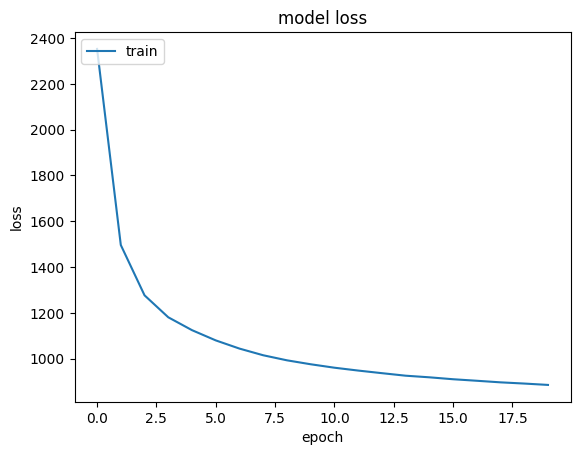

In [7]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


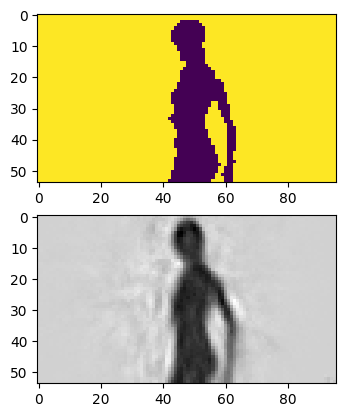

In [21]:
import matplotlib.pyplot as plt

test_image = cv2.imread('video_frames_bw/image_400.png')[:, :, 1]

plt.subplot(2, 1, 1)
plt.imshow(test_image)

predicted = auto_encoder.predict(np.array([test_image]))

plt.subplot(2, 1, 2)
plt.imshow(predicted.reshape(54, 96), cmap="gray")


6. Перевести все изображения в последовательность 128-мерных векторов.
7. Обучить рекуррентную нейронную сеть (подобрать параметры самостоятельно) предсказывать по текущему следующий вектор.
8. С помощью обученной сети сгенерировать последовательность векторов.
9. Перевести с помощью декодера последовательность векторов в последовательность кадров.
10. Средствами библиотек Python преобразовать кадры в видео.